#0. Load the Dataset from CSV Files

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel, RFECV

In [2]:
# Load processed training and test data
!ls -al
!mkdir prognostic

from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/My\ Drive/MLProjects/Prognostic/data/*.csv /content/prognostic
! ls -al /content/prognostic

total 16
drwxr-xr-x 1 root root 4096 Aug 27 16:17 .
drwxr-xr-x 1 root root 4096 Sep  3 09:03 ..
drwxr-xr-x 1 root root 4096 Aug 28 16:06 .config
drwxr-xr-x 1 root root 4096 Aug 27 16:17 sample_data
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
total 21116
drwxr-xr-x 2 root root     4096 Sep  3 10:13 .
drwxr-xr-x 1 root root     4096 Sep  3 10:13 ..
-rw------- 1 root root  2153095 Sep  3 10:13 test.csv
-rw------- 1 root root    78607 Sep  3 10:13 test_processed.csv
-rw------- 1 root root  3395968 Sep  3 10

In [3]:
df_train=pd.read_csv('prognostic/train_processed.csv')
df_test=pd.read_csv('prognostic/test_processed.csv')
df_test_original = pd.read_csv('prognostic/test.csv')

display(df_train.head(3), df_test.head(3), df_test_original.head(3))

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s1_av,s2_av,s3_av,s4_av,s5_av,s6_av,s7_av,s8_av,s9_av,s10_av,s11_av,s12_av,s13_av,s14_av,s15_av,s16_av,s17_av,s18_av,s19_av,s20_av,s21_av,s1_std,s2_std,s3_std,s4_std,s5_std,s6_std,s7_std,s8_std,s9_std,s10_std,s11_std,s12_std,s13_std,s14_std,s15_std,s16_std,s17_std,s18_std,s19_std,s20_std,s21_std,rul,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,518.67,641.820000,1589.700000,1400.600000,14.62,21.61,554.360000,2388.06,9046.190000,1.3,47.47,521.66,2388.020,8138.620000,8.419500,0.03,392.000000,2388.0,100.0,39.060000,23.4190,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,518.67,641.985000,1590.760000,1401.870000,14.62,21.61,554.055000,2388.05,9045.130000,1.3,47.48,521.97,2388.045,8135.055000,8.425650,0.03,392.000000,2388.0,100.0,39.030000,23.4213,0.0,0.233345,1.499066,1.796051,0.0,0.0,0.431335,0.014142,1.499066,0.0,0.014142,0.438406,0.035355,5.041671,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,518.67,642.106667,1589.836667,1402.646667,14.62,21.61,554.123333,2388.06,9047.733333,1.3,47.41,522.12,2388.040,8134.446667,8.423033,0.03,391.333333,2388.0,100.0,39.003333,23.3956,0.0,0.267644,1.918654,1.850009,0.0,0.0,0.327159,0.020000,4.632023,0.0,0.121655,0.404475,0.026458,3.717450,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s1_av,s2_av,s3_av,s4_av,s5_av,s6_av,s7_av,s8_av,s9_av,s10_av,s11_av,s12_av,s13_av,s14_av,s15_av,s16_av,s17_av,s18_av,s19_av,s20_av,s21_av,s1_std,s2_std,s3_std,s4_std,s5_std,s6_std,s7_std,s8_std,s9_std,s10_std,s11_std,s12_std,s13_std,s14_std,s15_std,s16_std,s17_std,s18_std,s19_std,s20_std,s21_std,rul,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,47.23,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552,518.67,642.44,1584.696667,1399.330000,14.62,21.61,554.223333,2388.083333,9049.986667,1.3,47.350000,521.986667,2388.076667,8132.676667,8.411533,0.03,392.000000,2388.0,100.0,38.973333,23.374733,0.0,0.437150,3.094614,1.475534,0.0,0.0,0.172143,0.005774,5.594375,0.0,0.104403,0.349333,0.020817,2.372706,0.009411,0.0,1.00000,0.0,0.0,0.145717,0.028070,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,2388.10,9044.77,1.3,47.67,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618,518.67,642.68,1587.293333,1408.673333,14.62,21.61,553.686667,2388.113333,9047.940000,1.3,47.536667,521.763333,2388.103333,8127.106667,8.439700,0.03,391.666667,2388.0,100.0,38.893333,23.283367,0.0,0.153948,0.612563,4.747803,0.0,0.0,0.491664,0.061101,3.917742,0.0,0.119304,0.455448,0.011547,1.570234,0.015373,0.0,0.57735,0.0,0.0,0.090738,0.018825,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,2388.16,9049.26,1.3,47.88,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740,518.67,643.06,1589.626667,1414.756667,14.62,21.61,552.663333,2388.160000,9048.406667,1.3,47.703333,520.610000,2388.170000,8131.030000,8.442600,0.03,394.666667,2388.0,100.0,38.723333,23.245433,0.0,0.180000,0.931146,3.580703,0.0,0.0,0.405010,0.030000,0.752152,0.0,0.153080,0.416173,0.036056,2.819699,0.026739,0.0,0.57735,0.0,0.0,0.188768,0.025085,69,0,0


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.2,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.5,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.5,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


# 1. Regression Modelling

## Regression Modelling

We will segment the Test and Training dataset into features dataframe and labels series

To make it easy to train models on different set of features, a variable to hold the set of features required was used to subset the original dataframe 

In [0]:
#original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

#original + extracted features
features_adxf = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
                 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18',
                 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18',
                 'sd19', 'sd20', 'sd21']

#features with low or no correlation with regression label
features_lowcr = ['setting3', 's1', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']

#features that have correlation with the regression label
features_corrl = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']

#a variable to hold the set of features to experiment with
features = features_orig

X_train = df_train[features]
y_train = df_train['rul']

X_test = df_test[features]
y_test = df_test['rul']

In [0]:
#Create helper class to calculate Regression Metrics
def get_regression_metrics(model, actual, predicted):
  """
  Args:
    model(str) - the model name identifier
    actual (serie) - contains the test value labels
    predicted(series) - contains the predicted value labels
  
  Returns:
    datafram: The combined metrics in single dataframe
  """
  regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                 }
  
  #return reg_metrics
  df_reg_metrics = pd.DataFrame.from_dict(regr_metrics, orient = 'index')
  df_reg_metrics.columns = [model]
  return df_reg_metrics


In [0]:
#Create a helper function to plot the coefficients weight or feature importance
def plot_features_weights(model, weights, feature_names, weights_type='c'):
  """
  Plot regression coefficients weights or feature importance
  
  Args:
    model(str): The model name identifier
    weights(array): Contains the regression coefficients weights or feature importance
    feature_names(list): Contains the corresponding feature names
    weight_type(str): 'c' for coefficients weight, otherwise is feature importance
    
  Returns:
    plot of either the regression coefficient weights or feature importance
 
  """
  
  (px, py) = (8,10) if len(weights)>30 else (8,5)
  W = pd.DataFrame({'Weights':weights}, feature_names)
  W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
  label = 'Coefficients' if weights_type == 'c' else 'Features Importance'
  
  plt.xlabel(model+label)
  plt.gca().legend_ = None

In [0]:
#Create a helper function to plot the regression residuals

def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
  """
  Print the Regression Residuals
  
  Args:
    model(str): the model name identifier
    y_train(series): the training labels
    y_train_pred(series): the predictions on training data
    y_test(series): the test labels
    y_test_pred(series): the predictions on the the test data
    
  Returns:
    Plot of the Regression Residuals
  """
  
  plt.scatter(y_train_pred, y_train_pred-y_train, c='blue', marker='o', label='Training Data')
  plt.scatter(y_test_pred, y_test_pred-y_test, c='lightgreen', marker='s', label='Test Data')
  
  plt.xlabel('Predicted Value')
  plt.ylabel('Residuals')
  plt.legend(loc= 'upper left')
  plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
  plt.title(model+' Residuals')
  plt.show()

## Base Model - Linear Regression

In [9]:
# Base Linear Regression
linear = linear_model.LinearRegression()
linear.fit(X_train, y_train)

y_test_predict = linear.predict(X_test)
y_train_predict = linear.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Reg', y_test, y_test_predict)
linreg_metrics

R^2 training: 0.580, R^2 test: 0.405


,Linear Reg
Root Mean Squared Error,32.041095
Mean Absolute Error,25.591780
R^2,0.405495
Explained Variance,0.665297


## Test Other Regression Algorithms

In [10]:
#Try Lasso
lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('LASSO', y_test, y_test_predict)
lasso_metrics

R^2 training: 0.579, R^2 test: 0.408


,LASSO
Root Mean Squared Error,31.966099
Mean Absolute Error,25.551808
R^2,0.408275
Explained Variance,0.668206


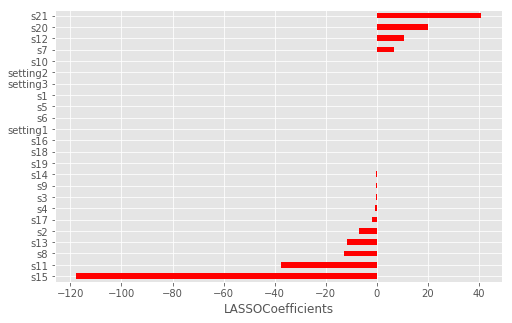

In [12]:
plot_features_weights('LASSO', lasso.coef_, X_train.columns, 'c')

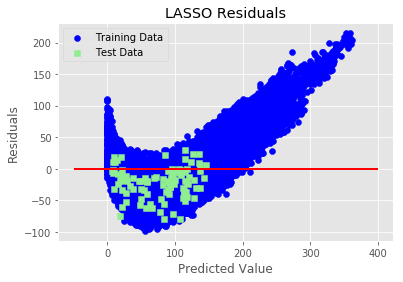

In [13]:
plot_residual('LASSO', y_train_predict, y_train, y_test_predict, y_test)

In [20]:
#try ridge

rdg = linear_model.Ridge(alpha=0.01)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict= rdg.predict(X_train)


print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics


R^2 training: 0.580, R^2 test: 0.408


,Ridge Regression
Root Mean Squared Error,31.965740
Mean Absolute Error,25.544620
R^2,0.408289
Explained Variance,0.667607


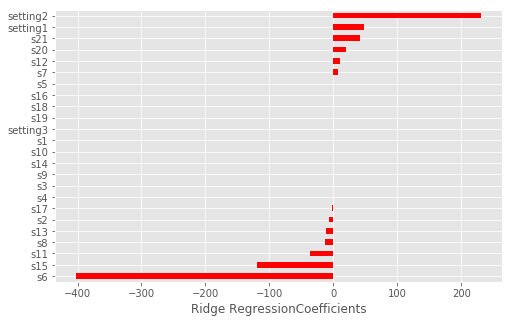

In [21]:
plot_features_weights('Ridge Regression', rdg.coef_, X_train.columns, 'c')

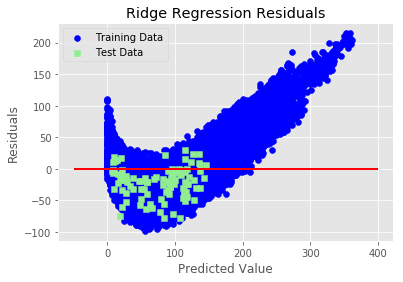

In [22]:
plot_residual('Ridge Regression', y_train_predict, y_train, y_test_predict, y_test)

In [23]:
#try Polynomial Regression

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict= polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.627, R^2 test: 0.387


,Polynomial Regression
Root Mean Squared Error,32.530030
Mean Absolute Error,24.944453
R^2,0.387213
Explained Variance,0.633327


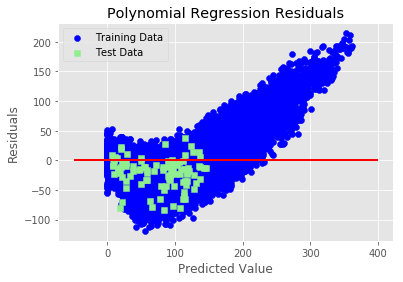

In [24]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)

As is expected Polynomial Regression has fared better than the linear regression model

In [25]:
#try Decision Tree regressor

#dtrg = DecisionTreeRegressor(max_depth=8, max_features=5, random_state=123) # selected features
dtrg = DecisionTreeRegressor(max_depth=7, random_state=123)
dtrg.fit(X_train, y_train)

y_test_predict = dtrg.predict(X_test)
y_train_predict = dtrg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

dtrg_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_test_predict)
dtrg_metrics

R^2 training: 0.625, R^2 test: 0.403


,Decision Tree Regression
Root Mean Squared Error,32.095349
Mean Absolute Error,24.319068
R^2,0.403480
Explained Variance,0.632767


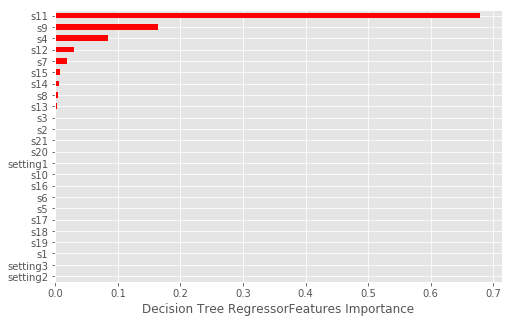

In [26]:
plot_features_weights('Decision Tree Regressor', dtrg.feature_importances_, X_train.columns, 't' )

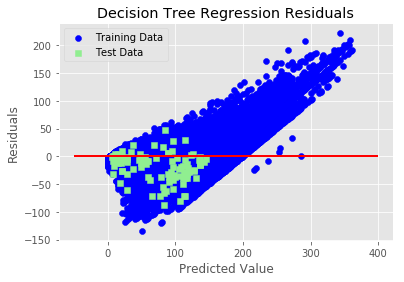

In [27]:
plot_residual('Decision Tree Regression', y_train_predict, y_train, y_test_predict, y_test)

Optimal number of features : 5
The selected features are: ['s4', 's7', 's9', 's11', 's12']


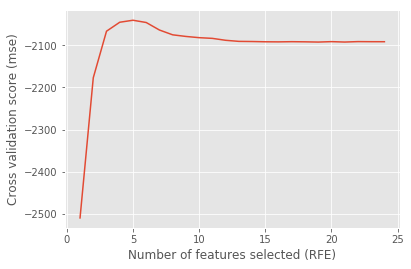

In [28]:
#try recursive feature elimination

kfold = model_selection.KFold(n_splits=5, random_state=10)

dtrg = DecisionTreeRegressor(max_depth=7)

rfecv = RFECV(estimator=dtrg, step=1, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

sel_features = [f for f,s in zip(X_train.columns, rfecv.support_) if s]
print('The selected features are: {}'.format(sel_features))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected (RFE)")
plt.ylabel("Cross validation score (mse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [29]:
# Decition Tree with selected features

#trnsform train and test data
X_train_trn = rfecv.transform(X_train)
X_test_trn = rfecv.transform(X_test)

print(X_train.shape)

dtrg = DecisionTreeRegressor(max_depth=7)

dtrg.fit(X_train_trn, y_train)

y_test_predict = dtrg.predict(X_test_trn)

dtrg_fs_metrics = get_regression_metrics('Decision Tree: Selected Features', y_test, y_test_predict)

#combine decision tree results: All features and selected features
dtr_metrics = pd.concat([dtrg_fs_metrics,dtrg_metrics], axis=1)

dtr_metrics

(20631, 24)


,Decision Tree: Selected Features,Decision Tree Regression
Root Mean Squared Error,34.212392,32.095349
Mean Absolute Error,25.866117,24.319068
R^2,0.322191,0.403480
Explained Variance,0.593892,0.632767


Model performance using only 5 top important features is comparable to using all 24 features.

Lets have a look at the percentage importance of these features

In [30]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(sel_features, dtrg.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

importances.sort_values(by='Importance', ascending=False)

,Importance
s11,0.682967
s9,0.168857
s4,0.091237
s12,0.033993
s7,0.022947


In [31]:
#try Random Forest

#rf = RandomForestRegressor(n_estimators=100, max_features=2, max_depth=4, n_jobs=-1, random_state=1) # selected features
rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=4, n_jobs=-1, random_state=1) # original features
#rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=7, n_jobs=-1, random_state=1) # orig + extrcted 

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.594, R^2 test: 0.525


,Random Forest Regression
Root Mean Squared Error,28.634253
Mean Absolute Error,23.167130
R^2,0.525198
Explained Variance,0.767320


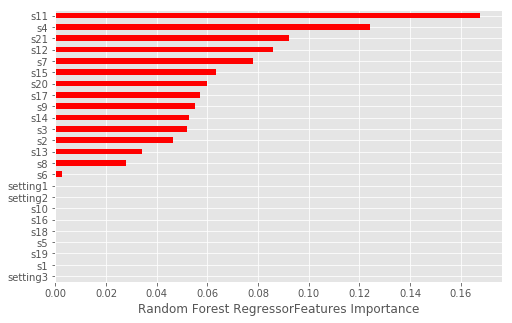

In [32]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )

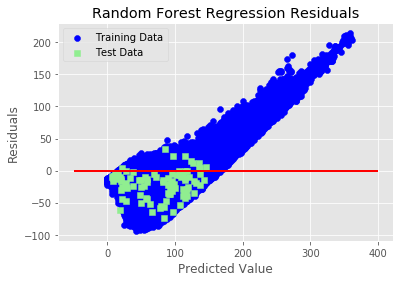

In [33]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)

regression residuals were not randomly spread across the average value of the residuals. This could be improved by fixing the data (e.g. outliers, resampling) or model parameters tuning.

Let us view predicted values

In [34]:
# view predictions vs actual

rf_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_test_predict
            }
    
rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Actual,112.000000,98.000000,69.000000,82.000000,91.00000,93.000000,91.000000,95.000000,111.00000,96.000000,97.0000,124.000000,95.00000,107.000000,83.000000,84.000000,50.000000,28.000000,87.000000,16.000000,57.000000,111.00000,113.000000,20.000000,145.000000,119.000000,66.000000,97.00000,90.000000,115.000000,8.000000,48.000000,106.000000,7.000000,11.000000,19.000000,21.000000,50.000000,142.000000,28.000000,...,21.000000,54.000000,72.000000,28.000000,128.000000,14.000000,77.00000,8.00000,121.000000,94.000000,118.0000,50.000000,131.00000,126.000000,113.000000,10.000000,34.000000,107.000000,63.000000,90.00000,8.000000,9.000000,137.000000,58.000000,118.00000,89.00000,116.000000,115.000000,136.000000,28.000000,38.000000,20.000000,85.00000,55.000000,128.000000,137.000000,82.000000,59.000000,117.000000,20.00000
Prediction,151.578408,119.268513,74.415647,96.470907,112.59338,130.279445,128.114019,100.692144,116.11839,127.369752,74.3702,108.928126,111.97524,114.536493,156.282221,141.445157,76.112088,74.765506,133.969586,29.800027,99.080066,138.99969,151.577454,49.988723,139.165295,144.898254,129.894492,122.46679,124.485877,115.945569,23.600092,86.326373,106.700074,16.454064,16.121201,28.620101,65.573096,64.179198,156.255114,27.998811,...,45.917472,78.269108,81.969786,53.908666,162.578261,23.566936,135.59351,19.44597,130.790774,113.696268,147.1769,101.133369,150.15836,114.010495,143.063171,19.500564,45.845112,160.525567,114.390374,102.09728,16.713524,17.761367,132.373095,70.655231,118.51855,111.07483,147.694806,130.444925,124.612641,46.908398,40.976045,33.031218,51.39622,64.318328,143.657061,159.663783,100.027659,103.182456,157.063688,35.62655


In [36]:
#regression metrics comparison before feature engineering
#linreg_metrics,
reg_metrics_bfe = pd.concat([ linreg_metrics, lasso_metrics, rdg_metrics, dtrg_metrics, polyreg_metrics, rf_metrics], axis=1)
reg_metrics_bfe

,Linear Reg,LASSO,Ridge Regression,Decision Tree Regression,Polynomial Regression,Random Forest Regression
Root Mean Squared Error,32.041095,31.966099,31.965740,32.095349,32.530030,28.634253
Mean Absolute Error,25.591780,25.551808,25.544620,24.319068,24.944453,23.167130
R^2,0.405495,0.408275,0.408289,0.403480,0.387213,0.525198
Explained Variance,0.665297,0.668206,0.667607,0.632767,0.633327,0.767320


**Regression Summary:**

In accordance with our analysis in the data exploratory phase, non-linear regression models like Polynomial and Random Forest performed better than linear models like OLS, LASSO and Ridge regression. Random Forest clearly outperformed other models scoring RMSE of 28.63 cycles, i.e. the model predicts TTF within average error range of ±28.63 cycles.

The hyper-parameter tuning for the Random Forest Regressor, LASSO, and Ridge models was done manually, but Grid Search or Random Search with Cross Validation could be used for better processing.